# Reinforcement Learning for Portfolio Optimization

This notebook demonstrates how to use Deep Reinforcement Learning (DRL) for asset allocation. We treat asset allocation not just as a one-step optimization problem, but as continuous control of the portfolio with the delayed reward. We move from optimal allocation to optimal control territory and in a data-driven world, it can be solved via various reinforcement learning algorithms. 

The idea would be to go beyond classical Markowitz effecient frontier and not just the structure of the market implicitly. but directly learn the policy of changing the weights dynamically in the continuously changing market!

The focus of this case study are as follows:
* Understand and build an Optimal Portfolio Allocation.
* Evaluate Q-Learning of reinforcement learning which is a combination of policy and value based reinforcement learning. 
* Understand approaches to define the reward functions, understand the reinfrocement learning algorithms and fine tune them.
* Create an simulation environment to be used in the reinforcement learning framework.


## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4.Evaluate Algorithms and Models](#4)        
    * [4.1. Defining the Environment](#4.1)
    * [4.2. Agent Script](#4.2)
    * [4.3. Training the model](#5.5)       
* [5.Testing the Model](#5)           

<a id='0'></a>
# 1. Introduction

In reinforcement learning, an agent makes observations and takes actions within an environment, and in return it receives rewards. Its objective is to learn to act in a way that will maximize its expected long-term rewards. 

In this notebook, we will use Q-learning applied to portfolio management is the following. In other words, we will use the DDPG algorithm to solve the optimal liquidation problem. But before we can apply the DDPG algorithm we first need to formulate the optimal liquidation problem so that in can be solved using reinforcement learning. In the next section we will see how to do this. 

The idea of Q-learning applied to portfolio management is the following: we can describe the market with some state s_t and with doing some action on this market and going to the state s_{t+1} we get a reward (changed value of our portfolio based on the weights we applied). The name “Q-learning” comes from the Q(s, a) function, that based on the market state s and provided action a (in our case, it’s allocation weights) returns the expected reward. Today this function can be approximated with deep neural networks and we can train such a model to optimize for a Sharpe ratio or any other criteria, but not just for a single allocation, but for a sequence of portfolio allocations, where we will exploit trained Q function for choosing the optimal actions. If you will check the source code for details, please notice, that for continuous action space with Deep Reinforcement Learning we need to use some tricks.


### Parameters

* Policy: agent's behaviour function, which is a map from state to actions
* Environment: a simulated trading environment, defined under syntheticChrissAlmgren.py module.
* Training: interactions between the agent and environment for the agent to learn what the goal is and how to achieve it the best
* Episode: number of independent training session (the environment is reset, but agent keeps the learning from one episode to another).
* Session: each session has multiple episodes with both environment and agent reset; the goal is to benchmark agent performances based on the number of episodes.

### Q-Learning
Q-learning is one of the most popular Reinforcement learning algorithms and lends itself much more readily for learning through implementation of toy problems as opposed to scouting through loads of papers and articles.

**DATA**

In the case of the cryptocurrency portfolio, we have selected 180 days for the decision-making period and reduced holding time to three months due to the understanding that the market is very volatile.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

Using TensorFlow backend.


In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

In [5]:
#The data already obtained from yahoo finance is imported.
dataset = read_csv('data/crypto_portfolio.csv',index_col=0)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
# shape
dataset.shape

(375, 15)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,ADA,BCH,BNB,BTC,DASH,EOS,ETH,IOT,LINK,LTC,TRX,USDT,XLM,XMR,XRP
Date,,,,,,,,,,,,,,,
2018-01-01,0.7022,2319.120117,8.480,13444.879883,1019.419983,7.64,756.200012,3.90,0.7199,224.339996,0.05078,1.01,0.4840,338.170013,2.05
2018-01-02,0.7620,2555.489990,8.749,14754.129883,1162.469971,8.30,861.969971,3.98,0.6650,251.809998,0.07834,1.02,0.5560,364.440002,2.19
2018-01-03,1.1000,2557.520020,9.488,15156.620117,1129.890015,9.43,941.099976,4.13,0.6790,244.630005,0.09430,1.01,0.8848,385.820007,2.73
2018-01-04,1.1300,2355.780029,9.143,15180.080078,1120.119995,9.47,944.830017,4.10,0.9694,238.300003,0.21010,1.02,0.6950,372.230011,2.73
2018-01-05,1.0100,2390.040039,14.850,16954.779297,1080.880005,9.29,967.130005,3.76,0.9669,244.509995,0.22400,1.01,0.6400,357.299988,2.51


The data is the historical data of several Cryptocurrencies

<a id='4'></a>
# 4. Evaluate Algorithms and Models

In [ ]:
We will look at the following Scripts :

1. Creating Environment 
2. Helper Functions
3. Training Agents


<a id='4.1'></a>
## 4.1. Creating a bitcoin environment

In [12]:
import numpy as np
import pandas as pd


#define a function portfolio
def portfolio(returns, weights):
    weights = np.array(weights)
    rets = returns.mean() * 252
    covs = returns.cov() * 252
    P_ret = np.sum(rets * weights)
    P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
    P_sharpe = P_ret / P_vol
    return np.array([P_ret, P_vol, P_sharpe])


class CryptoEnvironment:
    
    def __init__(self, prices = './data/crypto_portfolio.csv', capital = 1e6):       
        self.prices = prices  
        self.capital = capital  
        self.data = self.load_data()

    def load_data(self):
        data =  pd.read_csv(self.prices)
        try:
            data.index = data['Date']
            data = data.drop(columns = ['Date'])
        except:
            data.index = data['date']
            data = data.drop(columns = ['date'])            
        return data

    def preprocess_state(self, state):
        return state

    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):

        assert lookback <= t

        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()

        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)

    def get_reward(self, action, action_t, reward_t, alpha = 0.01):

        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() # * 252
            covs = returns.cov() # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])

        data_period = self.data[action_t:reward_t]
        weights = action
        returns = data_period.pct_change().dropna()

        sharpe = local_portfolio(returns, weights)[-1]
        sharpe = np.array([sharpe] * len(self.data.columns))          
        rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]

        return np.dot(returns, weights), rew
        


<a id='4.2'></a>
## 4.2. Agent Script

In this section, we will train an agent that will perform reinforcement learning based on the actor and critic networks. We will perform the following steps to achieve this:
* Create an agent class whose initial function takes in the batch size, state size, and an evaluation Boolean function, to check whether the training is ongoing.
* In the agent class, create the following methods:
* Create a Replay function that adds, samples, and evaluates a buffer.
* Add a new experience to the replay buffer memory
* Randomly sample a batch of experienced tuples from the memory. In the following function, we randomly sample states from a memory buffer. We do this so that the states that we feed to the model are not temporally correlated. This will reduce overfitting:
* Return the current size of the buffer memory
* The number of actions are defined as 3: sit, buy, sell
* Define the replay memory size
* Reward function is return 



In [18]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

<a id='4.3'></a>
## 4.3. Training the data

In [19]:
N_ASSETS = 15 #53
agent = Agent(N_ASSETS)
env = CryptoEnvironment()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
window_size = 180
episode_count = 2
batch_size = 32
rebalance_period = 90

Episode 0/2 epsilon 1.0


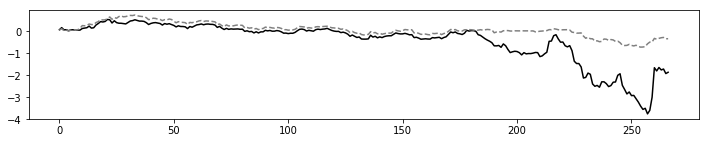

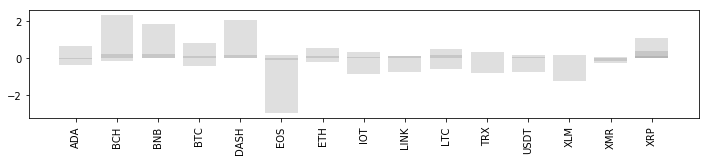

Episode 1/2 epsilon 1.0


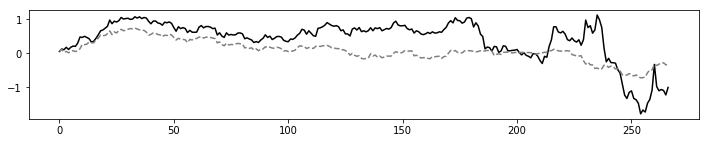

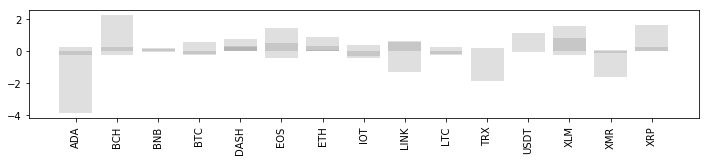

In [21]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):

        date1 = t-rebalance_period
        
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()
    

<a id='5'></a>
# 5. Testing the Data 

After training the data, it is tested it against the test dataset. Our model resulted in a total profit of $10427.24. The best thing about the model was that the profits kept improving over time, indicating that it was learning well and taking better actions.

In [22]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

In [23]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

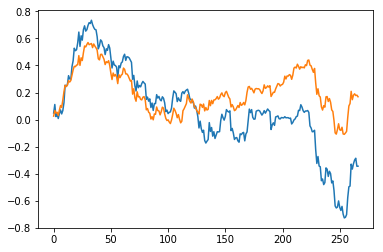

In [24]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum())
plt.plot(np.array(result_rl_vis).cumsum())
plt.show()

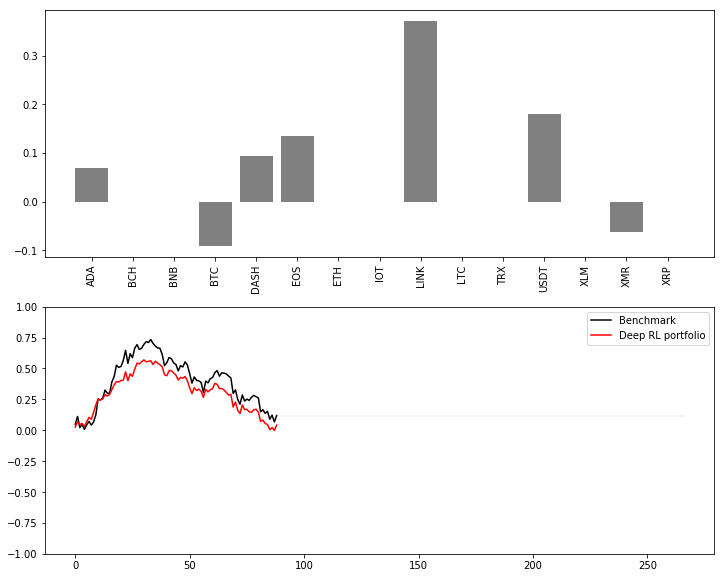

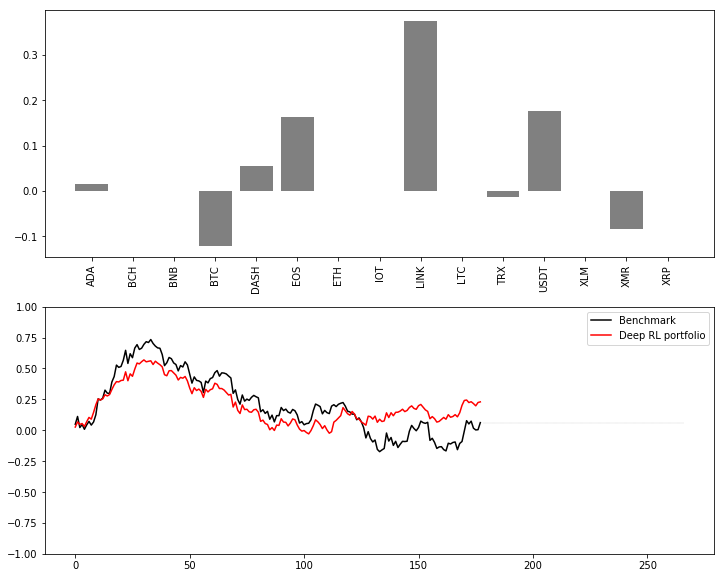

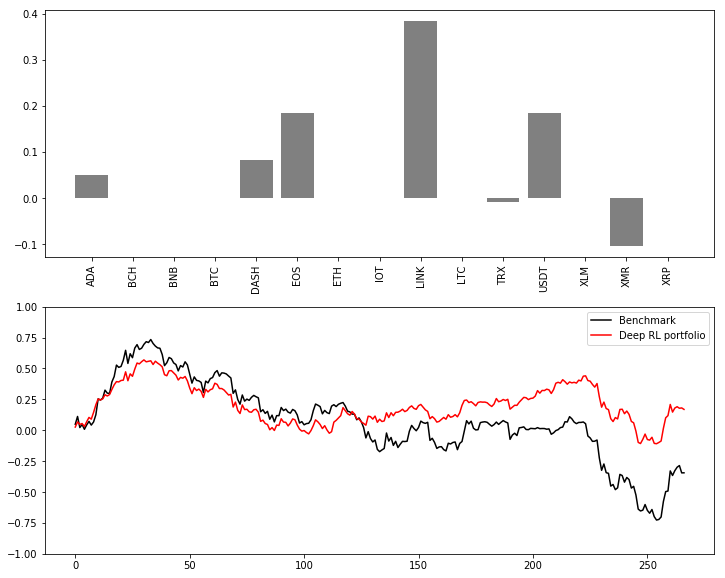

In [31]:
#Plotting the data
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

N = len(np.array([item for sublist in result_equal for item in sublist]).cumsum()) 

for i in range(0, len(actions_rl)):
    current_range = np.arange(0, N)
    current_ts = np.zeros(N)
    current_ts2 = np.zeros(N)

    ts_benchmark = np.array([item for sublist in result_equal[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in result_rl[:i+1] for item in sublist]).cumsum()

    t = len(ts_benchmark)
    current_ts[:t] = ts_benchmark
    current_ts2[:t] = ts_target

    current_ts[current_ts == 0] = ts_benchmark[-1]
    current_ts2[current_ts2 == 0] = ts_target[-1]

    plt.figure(figsize = (12, 10))

    plt.subplot(2, 1, 1)
    plt.bar(np.arange(N_ASSETS), actions_rl[i], color = 'grey')
    plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')

    plt.subplot(2, 1, 2)
    plt.colormaps = current_cmap
    plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
    plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = 'Deep RL portfolio')
    plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
    plt.autoscale(False)
    plt.ylim([-1, 1])
    plt.legend()

In [39]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))
    
    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [41]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

EQUAL [-0.0013, 0.0468, -0.5016, 0.0, 1.0]
RL AGENT [0.0006, 0.0338, 0.2528, 0.0014, 0.6047]


**Conclusion**

* In this case study, RL is implemented only as a proof-of-concept of multidimensional continuos-reward control, purely trained and evaluated on the in-sample data. Also, it tends to learn exploitation instead of exploitation more, which is another sign of ill setup. Last but not least, the input for the Q function approximation was the covariance matrix which might be not the best option. For the production use, more careful work is needed but this example can serve as a starting point.

* The idea would be to go beyond classical Markowitz effecient frontier and not just the structure of the market implicitly. but directly learn the policy of changing the weights dynamically in the continuously changing market!
